In [2]:
!pip install requests beautifulsoup4

In [3]:
import requests
from bs4 import BeautifulSoup
import os
from datetime import datetime

Searched up "Red Hat security data", got this link: https://access.redhat.com/security/data

In [4]:
BASE_URL = "https://security.access.redhat.com/data/csaf/v2/vex/2025/"
SAVE_DIR = "data/sep2025/"
os.makedirs(SAVE_DIR, exist_ok=True)

resp = requests.get(BASE_URL)
soup = BeautifulSoup(resp.text, "html.parser")

download_count = 0
MAX_DOWNLOADS = 100

for row in soup.select("tbody tr"):
    name_cell = row.find("td", class_="indexcolname")
    date_cell = row.find("td", class_="indexcollastmod")

    if not name_cell or not date_cell:
        continue

    href = name_cell.a.get("href") if name_cell.a else None
    lastmod_text = date_cell.get_text(strip=True)

    try:
        lastmod_dt = datetime.strptime(lastmod_text, "%a, %d %b %Y %H:%M:%S %z")
    except ValueError:
        continue

    # only keep September 2025
    if href and href.endswith(".json") and lastmod_dt.year == 2025 and lastmod_dt.month == 9:
        file_url = BASE_URL + href
        file_path = os.path.join(SAVE_DIR, href)

        r = requests.get(file_url)
        if r.status_code == 200:
            with open(file_path, "wb") as f:
                f.write(r.content)
            print(f"Saved {file_path}")
        else:
            print(f"Failed to download {href}")

        download_count += 1
        if download_count >= MAX_DOWNLOADS:
            print(f"Reached limit of {MAX_DOWNLOADS} downloads, stopping.")
            break

Saved data/sep2025/cve-2025-0009.json
Saved data/sep2025/cve-2025-0076.json
Saved data/sep2025/cve-2025-0077.json
Saved data/sep2025/cve-2025-0087.json
Saved data/sep2025/cve-2025-0089.json
Saved data/sep2025/cve-2025-0164.json
Saved data/sep2025/cve-2025-0165.json
Saved data/sep2025/cve-2025-0167.json
Saved data/sep2025/cve-2025-0237.json
Saved data/sep2025/cve-2025-0238.json
Saved data/sep2025/cve-2025-0239.json
Saved data/sep2025/cve-2025-0240.json
Saved data/sep2025/cve-2025-0241.json
Saved data/sep2025/cve-2025-0242.json
Saved data/sep2025/cve-2025-0243.json
Saved data/sep2025/cve-2025-0244.json
Saved data/sep2025/cve-2025-0245.json
Saved data/sep2025/cve-2025-0246.json
Saved data/sep2025/cve-2025-0247.json
Saved data/sep2025/cve-2025-0280.json
Saved data/sep2025/cve-2025-0291.json
Saved data/sep2025/cve-2025-0306.json
Saved data/sep2025/cve-2025-0312.json
Saved data/sep2025/cve-2025-0313.json
Saved data/sep2025/cve-2025-0315.json
Saved data/sep2025/cve-2025-0317.json
Saved data/s

In [5]:
import json
import pandas as pd
from pandas import json_normalize
import glob

json_files = glob.glob("data/sep2025/*.json")

rows = []

for file in json_files:
    with open(file, "r") as f:
        data = json.load(f)

        # metadata
        tracking = data.get("document", {}).get("tracking", {})
        cve_id = tracking.get("id")
        published = tracking.get("initial_release_date")
        modified = tracking.get("current_release_date")
        status = tracking.get("status")

        description = None
        for vuln in data.get("vulnerabilities", []):
            for note in vuln.get("notes", []):
                if note.get("category") == "description":
                    description = note.get("text")

            release_date = vuln.get("release_date")

            product_status = vuln.get("product_status", {})
            known_not_affected = product_status.get("known_not_affected", [])
            known_affected = product_status.get("known_affected", [])

            for product in known_not_affected:
                rows.append({
                    "CVE_ID": cve_id,
                    "Published": published,
                    "Modified": modified,
                    "Status": status,
                    "Release_Date": release_date,
                    "Product": product,
                    "Affected": False,
                    "Description": description
                })
            for product in known_affected:
                rows.append({
                    "CVE_ID": cve_id,
                    "Published": published,
                    "Modified": modified,
                    "Status": status,
                    "Release_Date": release_date,
                    "Product": product,
                    "Affected": True,
                    "Description": description
                })

df = pd.DataFrame(rows)
df.to_csv("data/sep2025.csv", index=False)
print(df.head())
#print(df.info())

          CVE_ID                         Published                   Modified  \
0  CVE-2025-0312  2025-03-20T10:10:53.551000+00:00  2025-09-10T07:10:10+00:00   
1  CVE-2025-0312  2025-03-20T10:10:53.551000+00:00  2025-09-10T07:10:10+00:00   
2  CVE-2025-0684         2025-02-18T18:00:00+00:00  2025-09-10T03:18:07+00:00   
3  CVE-2025-0684         2025-02-18T18:00:00+00:00  2025-09-10T03:18:07+00:00   
4  CVE-2025-0684         2025-02-18T18:00:00+00:00  2025-09-10T03:18:07+00:00   

  Status                      Release_Date  \
0  final  2025-03-20T10:10:53.551000+00:00   
1  final  2025-03-20T10:10:53.551000+00:00   
2  final         2025-02-18T18:00:00+00:00   
3  final         2025-02-18T18:00:00+00:00   
4  final         2025-02-18T18:00:00+00:00   

                                             Product  Affected  \
0  red_hat_ansible_automation_platform_2:ansible-...     False   
1  red_hat_ansible_automation_platform_2:ansible-...     False   
2           red_hat_enterprise_linux_1

In [6]:
top_products = (
    df.groupby("Product")["CVE_ID"]
      .nunique()
      .sort_values(ascending=False)
      .head(50)
)
print(top_products)

Product
red_hat_products                                             54
red_hat_openshift_container_platform_4:rhcos                 13
red_hat_enterprise_linux_10:firefox                          12
red_hat_enterprise_linux_6:firefox                           12
red_hat_enterprise_linux_6:firefox.src                       12
red_hat_enterprise_linux_10:firefox.src                      12
red_hat_enterprise_linux_9:firefox-x11-firefox:flatpak       12
red_hat_enterprise_linux_6:thunderbird.src                   10
red_hat_enterprise_linux_6:thunderbird                       10
red_hat_enterprise_linux_7:thunderbird.src                   10
red_hat_enterprise_linux_7:thunderbird                       10
red_hat_enterprise_linux_10:thunderbird.src                  10
red_hat_enterprise_linux_10:thunderbird                      10
red_hat_enterprise_linux_8:grub2-efi-aa64-modules             8
red_hat_enterprise_linux_8:grub2-efi-x64-modules              8
red_hat_enterprise_linux_8:grub2

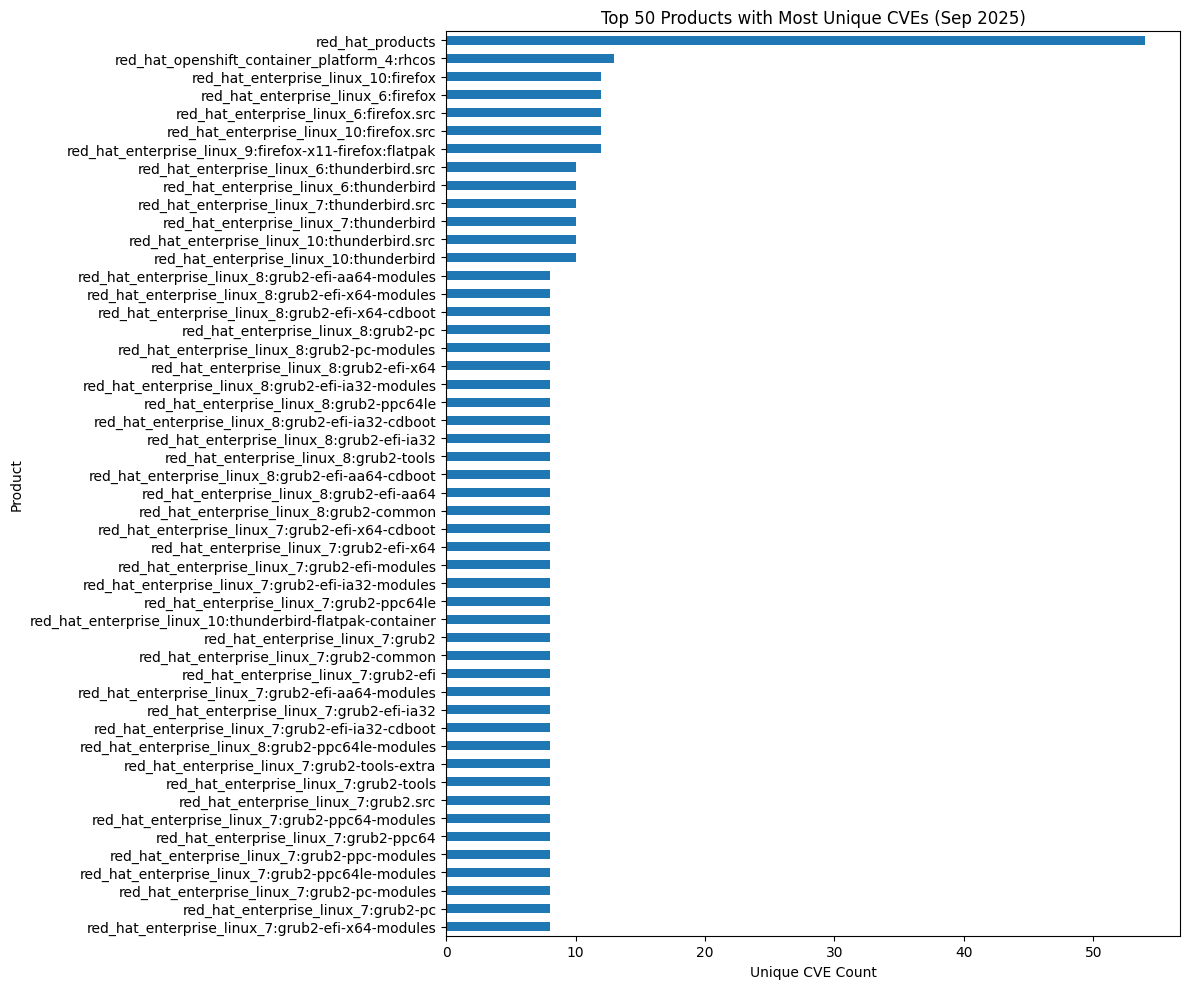

In [11]:
import matplotlib.pyplot as plt

top_products.plot(
    kind="barh",
    figsize=(12,10),
    title="Top 50 Products with Most Unique CVEs (Sep 2025)"
)
plt.xlabel("Unique CVE Count")
plt.ylabel("Product")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [8]:
from collections import Counter
import re
import nltk
from nltk.corpus import stopwords

nltk.download("stopwords")
stop_words = set(stopwords.words("english"))

words = []
for desc in df["Description"].dropna():
    for w in re.findall(r"\b[a-zA-Z]{5,}\b", desc.lower()):
        if w not in stop_words:
            words.append(w)

common_words = Counter(words).most_common(50)
print(common_words)

[('buffer', 7246), ('internal', 6731), ('found', 6217), ('network', 5986), ('variable', 5959), ('environment', 5902), ('function', 4118), ('result', 3780), ('using', 3712), ('issue', 3549), ('secure', 3457), ('execution', 3405), ('protections', 3358), ('controlled', 3331), ('write', 3273), ('bounds', 3234), ('length', 3227), ('information', 3213), ('allocating', 3194), ('resulting', 3101), ('exploited', 3044), ('process', 3008), ('fails', 2994), ('correctly', 2993), ('remote', 2979), ('configuration', 2952), ('trying', 2951), ('search', 2951), ('copies', 2951), ('consider', 2951), ('segment', 2951), ('searching', 2951), ('functions', 2252), ('could', 2171), ('libreoffice', 2010), ('shellexecute', 2010), ('system', 1596), ('vulnerability', 1519), ('paths', 1438), ('windows', 1340), ('mechanism', 1340), ('filesystem', 1210), ('glibc', 1155), ('service', 1097), ('overflow', 1082), ('attacker', 1067), ('arbitrary', 874), ('leading', 860), ('crafted', 718), ('called', 711)]


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


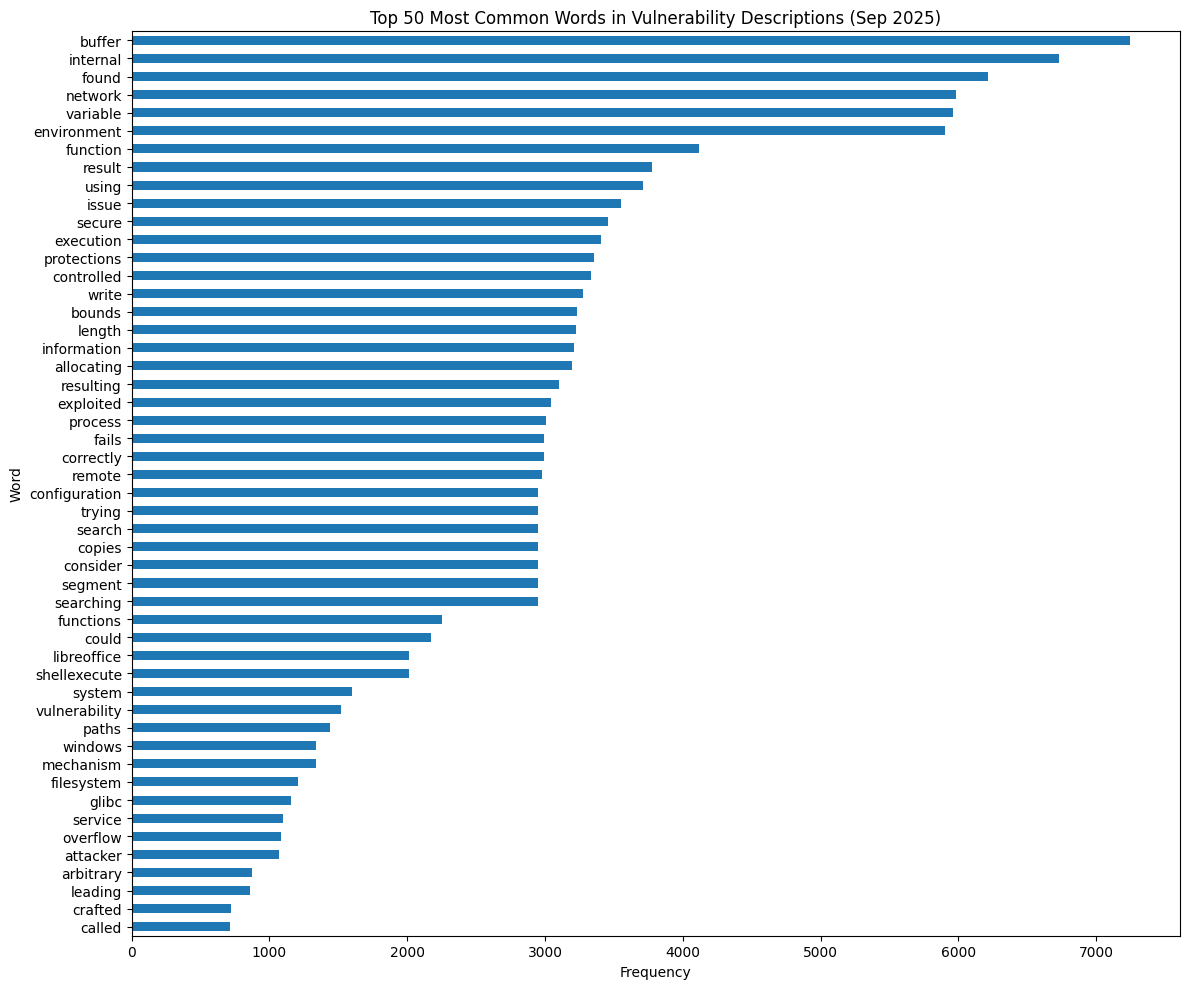

In [12]:
words_df = pd.DataFrame(common_words, columns=["Word", "Frequency"])
words_df.set_index("Word").plot(
    kind="barh",
    figsize=(12,10),
    legend=False,
    title="Top 50 Most Common Words in Vulnerability Descriptions (Sep 2025)"
)
plt.xlabel("Frequency")
plt.ylabel("Word")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()